In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.models import load_model

# Ensure Pillow is installed
!pip install Pillow

import PIL  # Ensure Pillow is imported

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
!pip install scikit-learn
!pip install matplotlib
!pip install h5py
!pip install scikit-plot
!pip install seaborn

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [ ]:
# Unzip the dataset (assuming it's already downloaded and located in the current directory)
zip_file_path = r"D:\Hybrid with 140k Real and Fake Faces\140k Real and Fake Faces.zip"
extract_to_path = r"D:\New folder\Hybrid with 140k Real and Fake Faces"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print("Extraction complete.")

Extraction complete.


In [ ]:
# List all available GPUs
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print("GPUs detected:")
    for gpu in gpus:
        print(f" - {gpu}")

    # Check if TensorFlow is using the GPU
    from tensorflow.python.client import device_lib
    devices = device_lib.list_local_devices()
    for device in devices:
        if device.device_type == "GPU":
            print(f"TensorFlow is using GPU: {device.name}")
else:
    print("No GPUs detected. TensorFlow will use the CPU.")

GPUs detected:
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow is using GPU: /device:GPU:0


In [ ]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = tf.nn.tanh(tf.tensordot(x, self.W, axes=[-1, 0]) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=[-1, 0]), axis=1)
        attention_weights = tf.expand_dims(attention_weights, axis=-1)
        weighted_sum = x * attention_weights
        return weighted_sum

# Residual Block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Custom CNN Model with EfficientNetB0 as base
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=2):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Make sure the residual block matches the base model output shape
    x = residual_block(x, x.shape[-1])
    x = residual_block(x, 256)
    x = residual_block(x, 512)

    x = AttentionLayer()(x)  # Apply attention mechanism here

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
custom_cnn_model = build_custom_cnn()
custom_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_cnn_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 7, 7, 1280)   14746880    ['efficientnetb0[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 1280)  5120        ['conv2d[0][0]']             

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np

# Noise injection function
def add_noise(img):
    noise_factor = 0.03
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=img.shape)
    img_noisy = img + noise
    img_noisy = np.clip(img_noisy, 0., 1.)
    return img_noisy

# Training augmentation with your specs + noise + interpolation
data_aug_train = ImageDataGenerator(
    rotation_range=12,          # 12 degrees rotation
    zoom_range=0.1,             # zoom ~1.1x
    height_shift_range=0.15,
    width_shift_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=add_noise
)

train_generator = data_aug_train.flow_from_directory(
    r'D:\New folder\Hybrid with 140k Real and Fake Faces\real_vs_fake\real-vs-fake\train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    classes=['fake', 'real'],
    seed=2,
    shuffle=True,
    interpolation='lanczos'
)

# Validation and test without augmentation, only resizing + interpolation
data_aug_val = ImageDataGenerator()
val_generator = data_aug_val.flow_from_directory(
    r'D:\New folder\Hybrid with 140k Real and Fake Faces\real_vs_fake\real-vs-fake\valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    classes=['fake', 'real'],
    seed=2,
    shuffle=True,
    interpolation='lanczos'
)

data_aug_test = ImageDataGenerator()
test_generator = data_aug_test.flow_from_directory(
    r'D:\New folder\Hybrid with 140k Real and Fake Faces\real_vs_fake\real-vs-fake\test',
    target_size=(224, 224),
    batch_size=205,
    class_mode='categorical',
    color_mode='rgb',
    classes=['fake', 'real'],
    shuffle=False,
    interpolation='lanczos'
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Found 100,200 validated image filenames belonging to 2 classes.
Found 20,200 validated image filenames belonging to 2 classes.
Found 20,100 validated image filenames belonging to 2 classes.


In [ ]:
import IPython
from IPython.display import display, Javascript
import threading
import time

def keep_alive_javascript():
    display(Javascript('''
        function KeepAlive() {
            console.log("Keeping alive");
            setInterval(function() {
                console.log("Sending keep-alive request");
                fetch("/", {method: "GET", keepalive: true});
            }, 60000);
        }
        KeepAlive();
    '''))

def background_keep_alive():
    while True:
        time.sleep(60)
        print("Background task running to keep the notebook alive...")

# Run the JavaScript keep-alive function
keep_alive_javascript()

# Start the background keep-alive thread
thread = threading.Thread(target=background_keep_alive)
thread.start()


<IPython.core.display.Javascript object>

Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to keep the notebook alive...
Background task running to k

In [ ]:
!pip install Pillow
!pip install h5py
!pip install scikit-plot


In [ ]:
pip install Pillow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import PIL


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.models import load_model

# Ensure Pillow is installed
!pip install Pillow


In [ ]:
# Train the model
history = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# Fine-tune the base model by unfreezing some layers
base_model = custom_cnn_model.layers[1]  # Accessing the base model from the custom model
base_model.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
custom_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# Save the best model
custom_cnn_model.save('best_model.h5')


Epoch 1/20
3125/3125 [==============================] - 881s 279ms/step - loss: 0.3833 - accuracy: 0.8285 - val_loss: 0.2771 - val_accuracy: 0.8816 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - 615s 197ms/step - loss: 0.2789 - accuracy: 0.8848 - val_loss: 0.2108 - val_accuracy: 0.9182 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 623s 199ms/step - loss: 0.2316 - accuracy: 0.9062 - val_loss: 0.1977 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 628s 201ms/step - loss: 0.2016 - accuracy: 0.9193 - val_loss: 0.1681 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 613s 196ms/step - loss: 0.1780 - accuracy: 0.9295 - val_loss: 0.1561 - val_accuracy: 0.9395 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 625s 200ms/step - loss: 0.1572 - accuracy: 0.9380 - val_loss: 0.1490 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 7/20
3125/3125 [============

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [2]:
# Train accuracy, test accuracy, test loss
train_accuracy = history.history['accuracy'][-1]
test_loss, test_accuracy = custom_cnn_model.evaluate(test_generator)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


98/98 [==============================] - 76s 772ms/step - loss: 0.0505 - accuracy: 0.9953
Training Accuracy: 0.9900
Test Accuracy: 0.9900
Test Loss: 0.0505


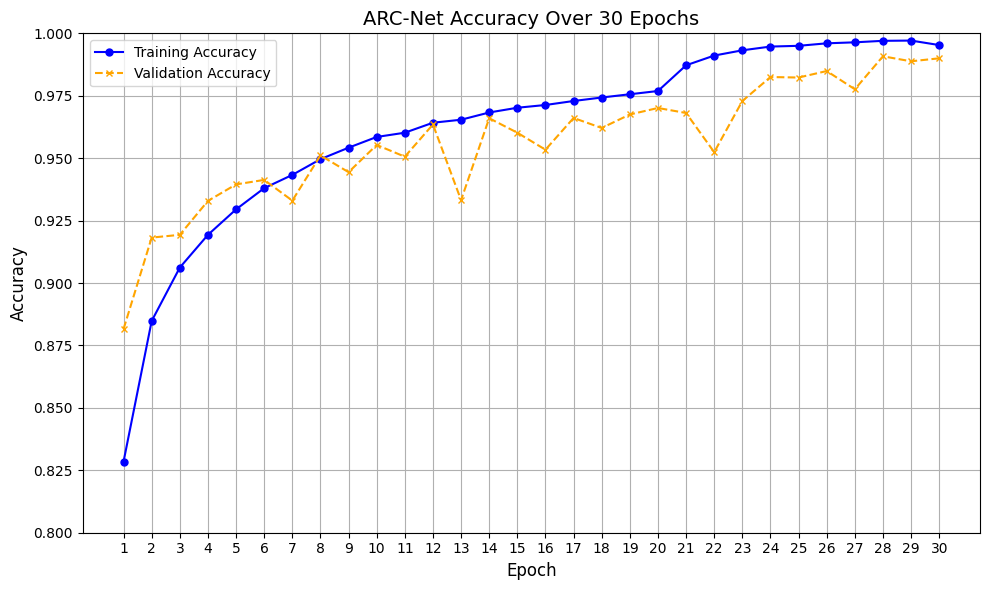

In [7]:
# Train vs test accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('ARC-Net Accuracy Over 30 Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [3]:
# Evaluate the model
test_loss, test_acc = custom_cnn_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Predict the test set
predictions = custom_cnn_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes


98/98 [==============================] - 36s 358ms/step - loss: 0.0505 - accuracy: 0.9900
Test accuracy: 0.9900
98/98 [==============================] - 36s 356ms/step


In [4]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

        fake       1.00      0.97      0.98     10000
        real       0.97      1.00      0.99     10100

    accuracy                           0.99     20100
   macro avg       0.99      0.99      0.99     20100
weighted avg       0.99      0.99      0.99     20100



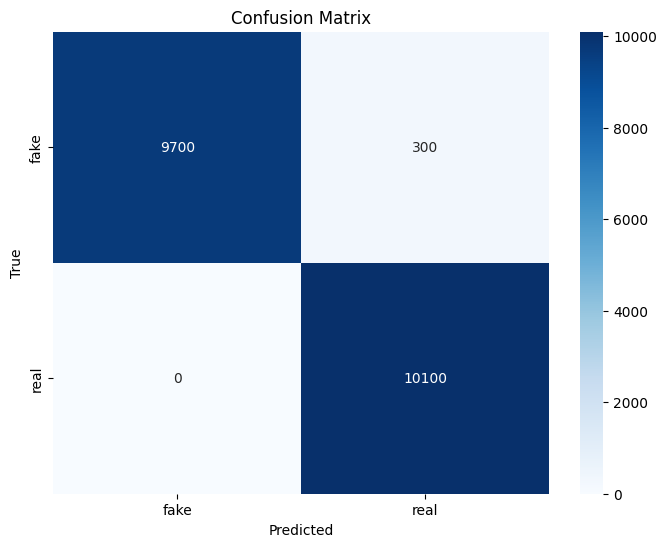

In [5]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()